In [1]:
import pandas as pd
import openai
import os
import urllib 
import time
import boto3
import json
import urllib.request
import pandas as pd

from datetime import datetime
dt = datetime.now()
ts = datetime.timestamp(dt)
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.getenv('OPENAI_API_KEY')
import json
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

In [4]:
#Obtenemos informacion de Bucket
audiofile = "2p.mp3"
client = boto3.client('transcribe')
job_name = f"TranscribeAudio-{audiofile}-{ts}"
response = client.start_transcription_job(
    TranscriptionJobName= job_name,
    LanguageCode= "es-US",
    Settings={
        'ShowSpeakerLabels': True,
        'MaxSpeakerLabels': 2,
        'ShowAlternatives': True,
        'MaxAlternatives': 3,
    },
    MediaFormat= "mp3",
    Media= {
        "MediaFileUri": f"s3://wizeline-generative-hackaton-audio-recordings/{audiofile}"
    }
)
max_tries = 60
while max_tries > 0:
    max_tries -= 1
    job = client.get_transcription_job(TranscriptionJobName=job_name)
    job_status = job['TranscriptionJob']['TranscriptionJobStatus']
    if job_status in ['COMPLETED', 'FAILED']:
        print(f"Job {job_name} is {job_status}.")
        if job_status == 'COMPLETED':
            print(
                f"Download the transcript from\n"
                f"\t{job['TranscriptionJob']['Transcript']['TranscriptFileUri']}.")
        break
    else:
        print(f"Waiting for {job_name}. Current status is {job_status}.")
    time.sleep(10)

with urllib.request.urlopen(job['TranscriptionJob']['Transcript']['TranscriptFileUri']) as url:
    s = url.read()
    data = json.loads(s)
    df = pd.DataFrame(data['results']['items'])
    df['confidence'] = df.alternatives.map(lambda x: x[0]['confidence'])
    df['content'] = df.alternatives.map(lambda x: x[0]['content'])
    scam_text = ' '.join(df.content)

Waiting for TranscribeAudio-2p.mp3-1689305842.016398. Current status is IN_PROGRESS.
Waiting for TranscribeAudio-2p.mp3-1689305842.016398. Current status is IN_PROGRESS.
Job TranscribeAudio-2p.mp3-1689305842.016398 is COMPLETED.
Download the transcript from
	https://s3.us-east-1.amazonaws.com/aws-transcribe-us-east-1-prod/689813869550/TranscribeAudio-2p.mp3-1689305842.016398/fe3943b5-31b8-4f09-a080-1fdb6799d008/asrOutput.json?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEIP%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIQDS9TbBWZyPlvtdTNKgHveuTxGLR1aECy3wM9jbXqt53QIgFuwy6KhkcmOCCVMnw1RPQ8OQP1diVtVy5Xo0DUmw7AoquwUI%2FP%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARAEGgwyNzY2NTY0MzMxNTMiDC8kqj3JJ3WxVSYpxiqPBf3GCNVAUCMAB56C8%2FcZwaM7NIG0npV1PSi7I64BtrPZq8eyKPTxbJh4HvdSykjDmDPiJ1rZmqLOgp73F1QVvxB%2FDsF0vl1mVc3cfLqGFM1pAjZxnIu7tM4IRkk0wOqwgKkG2NUmm7ICeGnaIEiRluZivZ3EHmVyjTprh6g4Dk%2FZN2U8EU72RbQPj92UUbMIMDly3GVEaH8q%2FeRCXdTBrgsR%2FzoWTWgfT3k5htdN8kkzUN6ZNItXGaY227tTt5%2BrgkLaklFY3BEalc6mH%2Bebn6uNVjpY5lhQ8

In [5]:
def get_completion(prompt, model="gpt-3.5-turbo",temperature=0): # Andrew mentioned that the prompt/ completion paradigm is preferable for this class
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

In [6]:
with urllib.request.urlopen(job['TranscriptionJob']['Transcript']['TranscriptFileUri']) as url:
    s = url.read()
    data = json.loads(s)
    df = pd.DataFrame(data['results']['items'])
    df['confidence'] = df.alternatives.map(lambda x: x[0]['confidence'])
    df['content'] = df.alternatives.map(lambda x: x[0]['content'])
    scam_text = ' '.join(df.content)

In [7]:
data

{'jobName': 'TranscribeAudio-2p.mp3-1689305842.016398',
 'accountId': '689813869550',
 'results': {'transcripts': [{'transcript': 'Hola. Soy representante de su banco. Hay un problema con su cuenta y necesitamos verificar su información de inmediato. A cuál es el problema exactamente? Puede darme más detalles? Eh, mire, hemos detectado actividad sospechosa en su cuenta y necesitamos confirmar su identidad para asegurarnos de que no se haya producido un fraude. Ok, entiendo. Eso es una preocupante. Y cómo puedo estar seguro de que realmente estás llamando desde mi banco? Y no se trata de una estafa, eh? Mira, por razones de seguridad, no puedo proporcionarte nuestra línea directa, pero puedo darte el número de atención al cliente general. Ok? Si ese es el caso, eh, Por favor dame el número del del banco para que yo pueda llamar directamente y verificar la situación. Ok? Eh, somos un departamento interno del banco y no podemos revelar nuestra identidad a través del teléfono.'}],
  'speak

In [55]:
scam_text = data['results']['transcripts'][0]['transcript']
scam_text

'Hola. Soy representante de su banco. Hay un problema con su cuenta y necesitamos verificar su información de inmediato. A cuál es el problema exactamente? Puede darme más detalles? Eh, mire, hemos detectado actividad sospechosa en su cuenta y necesitamos confirmar su identidad para asegurarnos de que no se haya producido un fraude. Ok, entiendo. Eso es una preocupante. Y cómo puedo estar seguro de que realmente estás llamando desde mi banco? Y no se trata de una estafa, eh? Mira, por razones de seguridad, no puedo proporcionarte nuestra línea directa, pero puedo darte el número de atención al cliente general. Ok? Si ese es el caso, eh, Por favor dame el número del del banco para que yo pueda llamar directamente y verificar la situación. Ok? Eh, somos un departamento interno del banco y no podemos revelar nuestra identidad a través del teléfono.'

In [42]:
data.keys()

dict_keys(['jobName', 'accountId', 'results', 'status'])

In [56]:
df = pd.DataFrame(data['results']['items'])
df

,start_time,speaker_label,end_time,alternatives,type
0,0.469,spk_0,0.819,"[{'confidence': '0.999', 'content': 'Hola'}]",pronunciation
1,NaN,spk_0,NaN,"[{'confidence': '0.0', 'content': '.'}]",punctuation
2,1.019,spk_0,1.22,"[{'confidence': '0.998', 'content': 'Soy'}]",pronunciation
3,1.23,spk_0,1.86,"[{'confidence': '0.995', 'content': 'represent...",pronunciation
4,1.87,spk_0,1.96,"[{'confidence': '0.997', 'content': 'de'}]",pronunciation
...,...,...,...,...,...
164,55.279,spk_0,55.34,"[{'confidence': '0.992', 'content': 'a'}]",pronunciation
165,55.349,spk_0,55.63,"[{'confidence': '0.984', 'content': 'través'}]",pronunciation
166,55.639,spk_0,55.79,"[{'confidence': '0.983', 'content': 'del'}]",pronunciation
167,55.799,spk_0,56.24,"[{'confidence': '0.996', 'content': 'teléfono'}]",pronunciation


In [60]:
df.speaker_label.value_counts()

spk_0    99
spk_1    70
Name: speaker_label, dtype: int64

In [57]:
df['confidence'] = df.alternatives.map(lambda x: x[0]['confidence'])
df['content'] = df.alternatives.map(lambda x: x[0]['content'])

In [58]:
scam_text

'Hola. Soy representante de su banco. Hay un problema con su cuenta y necesitamos verificar su información de inmediato. A cuál es el problema exactamente? Puede darme más detalles? Eh, mire, hemos detectado actividad sospechosa en su cuenta y necesitamos confirmar su identidad para asegurarnos de que no se haya producido un fraude. Ok, entiendo. Eso es una preocupante. Y cómo puedo estar seguro de que realmente estás llamando desde mi banco? Y no se trata de una estafa, eh? Mira, por razones de seguridad, no puedo proporcionarte nuestra línea directa, pero puedo darte el número de atención al cliente general. Ok? Si ese es el caso, eh, Por favor dame el número del del banco para que yo pueda llamar directamente y verificar la situación. Ok? Eh, somos un departamento interno del banco y no podemos revelar nuestra identidad a través del teléfono.'

In [13]:
scam_text = ' '.join(df.content)
scam_text
formato_json = """
{
  "score": ,
  "frases_clave_scam": [
    {
      "frase": ,
      "score_scam": ,
      "justificacion": ,
      "recomendacion": ,
      "sentimiento": 
    },
    {
      "frase": ,
      "score_scam": ,
      "justificacion": ,
      "sentimiento": 
    }
  ],
}"""

In [59]:
prompt = f"""
Imagina que eres un modelo de inteligencia artificial de "scam detector". Évalua "{scam_text}" . 
1- Genera un score de un solo número del 1 al 100 y una lista de frases clave pequeñas del texto de scam con su score de scam. 
2- Por cada frase de scam en el texto 
3- justifica el score asignado en 10 palabras. 
4- Agrega recomendiaciones particulares para cada frase.
5- Agrega el sentimiento de cada frase en "Positivo", "Negativo"
5- Muestras los resultados en formato json con este formato: {formato_json}, en español.
"""
response = get_completion(prompt)
print(response)

{
  "score": 85,
  "frases_clave_scam": [
    {
      "frase": "Hay un problema con su cuenta y necesitamos verificar su información de inmediato.",
      "score_scam": 90,
      "justificacion": "La frase genera urgencia y solicita información personal de manera inmediata.",
      "recomendacion": "No proporcione información personal de inmediato. Verifique la autenticidad de la llamada contactando directamente al banco.",
      "sentimiento": "Negativo"
    },
    {
      "frase": "Hemos detectado actividad sospechosa en su cuenta y necesitamos confirmar su identidad.",
      "score_scam": 80,
      "justificacion": "La frase genera preocupación y solicita confirmación de identidad sin proporcionar detalles específicos.",
      "recomendacion": "No proporcione información personal sin verificar la autenticidad de la llamada. Contacte directamente al banco para confirmar la situación.",
      "sentimiento": "Negativo"
    },
    {
      "frase": "No puedo proporcionarte nuestra línea 

In [16]:
out = json.loads(response)
score = out['score']
phrases = pd.DataFrame(out['frases_clave_scam'])

In [45]:
df

,start_time,speaker_label,end_time,alternatives,type,confidence,content
0,0.469,spk_0,0.819,"[{'confidence': '0.999', 'content': 'Hola'}]",pronunciation,0.999,Hola
1,NaN,spk_0,NaN,"[{'confidence': '0.0', 'content': '.'}]",punctuation,0.0,.
2,1.019,spk_0,1.22,"[{'confidence': '0.998', 'content': 'Soy'}]",pronunciation,0.998,Soy
3,1.23,spk_0,1.86,"[{'confidence': '0.995', 'content': 'represent...",pronunciation,0.995,representante
4,1.87,spk_0,1.96,"[{'confidence': '0.997', 'content': 'de'}]",pronunciation,0.997,de
...,...,...,...,...,...,...,...
164,55.279,spk_0,55.34,"[{'confidence': '0.992', 'content': 'a'}]",pronunciation,0.992,a
165,55.349,spk_0,55.63,"[{'confidence': '0.984', 'content': 'través'}]",pronunciation,0.984,través
166,55.639,spk_0,55.79,"[{'confidence': '0.983', 'content': 'del'}]",pronunciation,0.983,del
167,55.799,spk_0,56.24,"[{'confidence': '0.996', 'content': 'teléfono'}]",pronunciation,0.996,teléfono


In [46]:
phrases

,frase,score_scam,justificacion,recomendacion,sentimiento,start_word,end_word,start_time,end_time
0,Hay un problema con su cuenta y necesitamos ve...,90.0,La frase indica una urgencia y solicita inform...,No proporcione información personal por teléfo...,Negativo,Hay,inmediato.,NaN,None
1,Hemos detectado actividad sospechosa en su cue...,80.0,La frase genera preocupación y solicita confir...,No brinde información personal por teléfono. V...,Negativo,Hemos,identidad.,NaN,None
2,"No puedo proporcionarte nuestra línea directa,...",50.0,La frase genera desconfianza al no proporciona...,No confíe en números proporcionados por llamad...,Negativo,No,general.,NaN,None


def get_time(x):
    

In [20]:
phrases['start_word'] = phrases.frase.map(lambda x: x.split(' ')[0])
phrases['end_word'] = phrases.frase.map(lambda x: x.split(' ')[-1])
phrases

,frase,score_scam,justificacion,recomendacion,sentimiento,start_word,end_word
0,Hay un problema con su cuenta y necesitamos ve...,90,La frase indica una urgencia y solicita inform...,No proporcione información personal por teléfo...,Negativo,Hay,inmediato.
1,Hemos detectado actividad sospechosa en su cue...,80,La frase genera preocupación y solicita confir...,No brinde información personal por teléfono. V...,Negativo,Hemos,identidad.
2,"No puedo proporcionarte nuestra línea directa,...",50,La frase genera desconfianza al no proporciona...,No confíe en números proporcionados por llamad...,Negativo,No,general.


In [47]:
[i for i in phrases.loc[0, 'frase'].split(' ')] 

['Hay',
 'un',
 'problema',
 'con',
 'su',
 'cuenta',
 'y',
 'necesitamos',
 'verificar',
 'su',
 'información',
 'de',
 'inmediato.']

In [52]:
phrases['start_time'] = None
phrases['end_time'] = None
for index_frase, frase in enumerate(phrases.frase):
    words = frase.split(' ')
    first_word = words[0]
    last_word = words[-1]

    len_phrase = len(words) 

    temp_df = df[df.content == first_word]
    print('------> ', first_word, last_word)
    for i in temp_df.index:
        print(df.loc[i, 'content'], df.loc[i + len_phrase - 1, 'content'])
        if (df.loc[i, 'content']== first_word) and (df.loc[i + len_phrase - 1, 'content']== last_word):
            print('yes')
            phrases.loc[index_frase, 'start_time'] = df.loc[i, 'start_time']
            phrases.loc[index_frase, 'end_time'] = df.loc[i + len_phrase - 1, 'end_time']


------>  Hay inmediato.
Hay inmediato
------>  Hemos identidad.
------>  No general.


In [49]:
phrases

,frase,score_scam,justificacion,recomendacion,sentimiento,start_word,end_word,start_time,end_time
0,Hay un problema con su cuenta y necesitamos ve...,90.0,La frase indica una urgencia y solicita inform...,No proporcione información personal por teléfo...,Negativo,Hay,inmediato.,None,None
1,Hemos detectado actividad sospechosa en su cue...,80.0,La frase genera preocupación y solicita confir...,No brinde información personal por teléfono. V...,Negativo,Hemos,identidad.,None,None
2,"No puedo proporcionarte nuestra línea directa,...",50.0,La frase genera desconfianza al no proporciona...,No confíe en números proporcionados por llamad...,Negativo,No,general.,None,None


In [41]:
df_temp

,frase,score_scam,justificacion,recomendacion,sentimiento,start_word,end_word,start_time,end_time
0,Hay un problema con su cuenta y necesitamos ve...,90.0,La frase indica una urgencia y solicita inform...,No proporcione información personal por teléfo...,Negativo,Hay,inmediato.,NaN,None
1,Hemos detectado actividad sospechosa en su cue...,80.0,La frase genera preocupación y solicita confir...,No brinde información personal por teléfono. V...,Negativo,Hemos,identidad.,NaN,None
2,"No puedo proporcionarte nuestra línea directa,...",50.0,La frase genera desconfianza al no proporciona...,No confíe en números proporcionados por llamad...,Negativo,No,general.,NaN,None
3,"No puedo proporcionarte nuestra línea directa,...",50.0,La frase genera desconfianza al no proporciona...,No confíe en números proporcionados por llamad...,Negativo,No,general.,NaN,None


In [38]:
phrases.dtypes

frase             object
score_scam       float64
justificacion     object
recomendacion     object
sentimiento       object
start_word        object
end_word          object
start_time        object
end_time          object
dtype: object

In [39]:
phrases['score_scam'] = phrases['score_scam'].astype(float)
phrases['start_time'] = phrases['start_time'].astype(float)

KeyError: 'x'

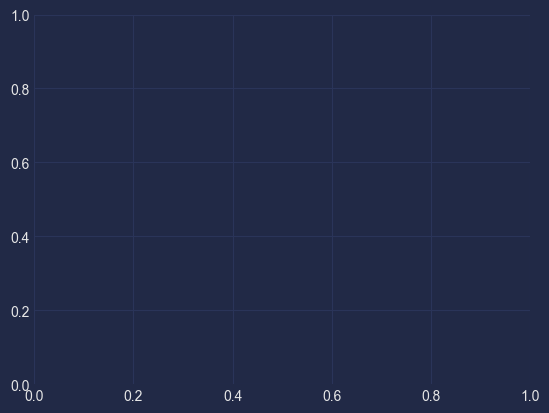

In [40]:
df_temp = phrases.copy()
df_temp.loc[len(df_temp.index)] = df_temp.iloc[-1]
df_temp.loc[len(df_temp.index) - 1, 'start_time'] = df_temp.loc[len(df_temp.index) - 1, 'end_time']
plot = sns.lineplot(data=df_temp, x = 'start_time', y = 'score_scam', color = 'r').set(title='Scam Score')
for i in phrases.index:
    x = float(phrases.loc[i, 'start_time'])
    y = float(phrases.loc[i, 'score'])
    text = phrases.loc[i, 'phrase']
    _ = plt.annotate(text, xy=(x,y), xytext=(x, y - 10),
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=10, width=2, color = 'white'))
plt.xlabel("Score")
plt.xlabel("Time [s]")
#plt.xlim(0,phrases.end_time.max())
mplcyberpunk.add_glow_effects(gradient_fill=True)

In [ ]:

phrases['emoji'] = phrases['sentiment'].map(lambda x: '😃' if x == 'feliz' else '☹️' )

/var/folders/r4/g6b0q1650fdbyb5v7h56z8vr0000gn/T/ipykernel_71337/1549154056.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ = plt.annotate(phrase, xy=(x,y), xytext=(x, y - 10),
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.


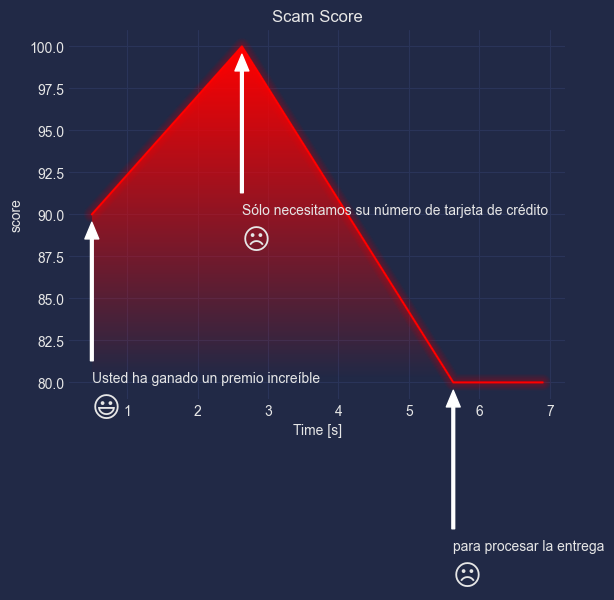

In [ ]:
df_temp = phrases.copy()
df_temp.loc[len(df_temp.index)] = df_temp.iloc[-1]
df_temp.loc[len(df_temp.index) - 1, 'start_time'] = df_temp.loc[len(df_temp.index) - 1, 'end_time']
plot = sns.lineplot(data=df_temp, x = 'start_time', y = 'score', color = 'r').set(title='Scam Score')
for i in phrases.index:
    x = float(phrases.loc[i, 'start_time'])
    y = float(phrases.loc[i, 'score'])
    text = phrases.loc[i, 'emoji']
    phrase = phrases.loc[i, 'phrase']

    _ = plt.annotate(phrase, xy=(x,y), xytext=(x, y - 10),
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=10, width=2, color = 'white'))
    
    _ = plt.annotate(text, xy=(x,y), xytext=(x, y - 12),
             fontname='Segoe UI Emoji', # this is the param added
        fontsize=20)
plt.xlabel("Score")
plt.xlabel("Time [s]")
#plt.xlim(0,phrases.end_time.max())
mplcyberpunk.add_glow_effects(gradient_fill=True)